# Simulation study: Bayesian linear regression, targeting the uncertainty

This notebooks corresponds to the experiments of Section 5.5 of the supplementary materials

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.gamma import Gamma

from src.weights_optimizer import WeightsOptimizer
from src.bayes_lin_reg import NIGLinearRegression
from src.utils import to_np, nig_kl_div, to_tensor

from tqdm import tqdm

# 1. Linear regression setup

## 1.1 Generate the synthetic dataset

In [2]:
dim = 1
n_points = 100
torch.manual_seed(0)
X = torch.randn(n_points, dim) * 1
X = torch.cat((torch.ones(n_points, 1), X), dim=1)

sigma = 0.5
true_beta = torch.tensor([0.5, 0.3], dtype=torch.float) 

y = X @ true_beta + torch.randn(n_points) * sigma
data = {"X": X, "y": y}

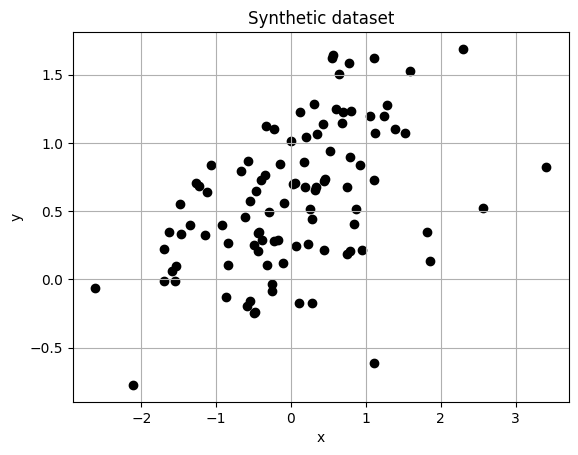

In [3]:
plt.scatter(X.data[:, 1], y.data, color="black")
plt.title("Synthetic dataset")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 1.2 Initialize linear regression model

In [4]:
# Prior
mu0 = torch.zeros(dim + 1, dtype=torch.float32)  # Prior mean vector for beta, including intercept
v0 = torch.eye(dim + 1, dtype=torch.float32) * 100  # Prior covariance matrix for beta, including intercept
a0 = 2.0  # Shape parameter for the inverse gamma prior 
b0 = 2.0 # Rate parameter for the inverse gamma prior

model = NIGLinearRegression(mu0, v0, a0, b0)

## 1.3 Define the adversarial target distribution

In [5]:
decrease_uncertainty = False

idx_covariate = 1
target_std_scaling_factor = 10

muA, vA, aA, bA = model.posterior_parameters(data)
original_std = torch.sqrt(vA[idx_covariate, idx_covariate])
print("Original conditional std:", to_np(original_std))
target_std_val = original_std * target_std_scaling_factor
if decrease_uncertainty:
    target_std_val = original_std / target_std_scaling_factor

v_cholesky = torch.linalg.cholesky(vA)
v_cholesky[idx_covariate, idx_covariate] = target_std_val
vA = v_cholesky @ v_cholesky.T

tauA = aA / bA
tau_adv_dist = Gamma(aA, bA)
beta_adv_dist = MultivariateNormal(muA, vA / tauA)

def sample_adv(n_samples):
    """
    Samples from the adversarial target

    Parameters:
    - n_samples: shape of the output tensor
    """
    
    # Sample the posterior
    sigma2_sample = 1.0 / ( tau_adv_dist.sample(torch.tensor([n_samples])) )
    centered_beta_dist = MultivariateNormal(torch.zeros_like(muA), vA)
    beta_sample = centered_beta_dist.sample((n_samples, ))

    beta_sample = muA + (torch.sqrt(sigma2_sample) * beta_sample.T).T

    return {'beta': beta_sample, 'sigma2': sigma2_sample}


Original conditional std: 0.09760968


In [6]:
n_samples_post = 10000
torch.manual_seed(0)
original_marginal_std = torch.std(model.sample_posterior(n_samples_post, data)["beta"][:, idx_covariate])
print("Original marginal std:", to_np(original_marginal_std))

Original marginal std: 0.047943212


# 2. Run Heuristics

In [7]:
results = {}
max_occurence = 2 
max_L1_list = range(5, 56, 5)
n_repeats = 30

params_FGSM = {"heuristic": "FGSM",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": None,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_ISCD = {"heuristic": "2O-ISCD",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": 65,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_R2 = {"heuristic": "2O-R2",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": 20,
               "stopping_ratio": 1e-3,
               "betas": None,
               "eps": 1e-1,
               "lr": None
                }

params_dicts_list = [params_FGSM, params_2O_ISCD, params_2O_R2]

Structure of the results dictionary:

dict: (heuristic -> dict: (max_L1 -> dict: (param -> tensor of shape (n_repeats, param_shape))))

In [8]:
torch.manual_seed(0)

for params_dict in params_dicts_list:

    print(params_dict["heuristic"])
    
    results_heuristic = {}
    
    for max_L1 in tqdm(max_L1_list):
            
        results_L1 = {  "weights": [], 
                        "L1": [], 
                        "a": [], 
                        "b": [],
                        "mean": [], 
                        "cov": [],
                        "KLs": [], 
                        "iterations": []}
        
        for i in range(n_repeats):
            

            opti = WeightsOptimizer(data, model, sample_adv)

            weights = opti.optimize(max_occurence=max_occurence, max_L1=max_L1,
                                            heuristic=params_dict["heuristic"],
                                            n_MC_samples_adv=params_dict["n_MC_samples_adv"],
                                            n_MC_samples_post=params_dict["n_MC_samples_post"],
                                            max_iterations=params_dict["max_iterations"],
                                            stopping_ratio=params_dict["stopping_ratio"],
                                            eps=params_dict["eps"],
                                            lr=params_dict["lr"],
                                            verbose=False, 
                                            make_plots=False,
                                            rounding=True,
                                            L2_constraints=False)
                        
            mu_ast, v_ast, a_ast, b_ast = model.posterior_parameters(data, weights=weights) 
            tau_post = Gamma(a_ast, b_ast)
            beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

            kl_est = float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post).detach().numpy())

            results_L1["weights"].append(weights)
            L1 = float(torch.norm(torch.ones(n_points) - weights, p=1))
            results_L1["L1"].append(L1)
            results_L1["a"].append(a_ast)
            results_L1["b"].append(b_ast)
            results_L1["mean"].append(mu_ast)
            results_L1["cov"].append(v_ast)
            results_L1["KLs"].append(kl_est)
            iterations = 1 if "R2" not in params_dict["heuristic"] else opti.iteration + 1
            results_L1["iterations"].append(iterations)
        
        # Store as tensors
        for key in results_L1.keys():
            results_L1[key] = to_tensor(results_L1[key])
        
        # Save the dictionary of results for this max_L1 value
        results_heuristic[max_L1] = results_L1

        
    # Save the dictionary of results for this heuristic
    results[params_dict["heuristic"]] = results_heuristic

    if "R2" in params_dict["heuristic"]:
        for max_L1 in max_L1_list:
            nb_iterations = results_heuristic[max_L1]["iterations"].float()
            nb_not_converged = to_np(sum(nb_iterations == params_dict["max_iterations"]))
            mean_iter = int(nb_iterations.mean())
            std_iter = int(nb_iterations.std())
            print(f"Max L1: {max_L1}, iterations: {mean_iter} +- {std_iter}, {nb_not_converged} did not converge")


FGSM


100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


2O-ISCD


100%|██████████| 11/11 [20:12<00:00, 110.26s/it]


2O-R2


100%|██████████| 11/11 [02:22<00:00, 12.94s/it]

Max L1: 5, iterations: 2 +- 0, 0 did not converge
Max L1: 10, iterations: 2 +- 0, 0 did not converge
Max L1: 15, iterations: 2 +- 0, 0 did not converge
Max L1: 20, iterations: 2 +- 0, 0 did not converge
Max L1: 25, iterations: 2 +- 0, 0 did not converge
Max L1: 30, iterations: 3 +- 0, 0 did not converge
Max L1: 35, iterations: 3 +- 0, 0 did not converge
Max L1: 40, iterations: 3 +- 0, 0 did not converge
Max L1: 45, iterations: 3 +- 0, 0 did not converge
Max L1: 50, iterations: 3 +- 0, 0 did not converge
Max L1: 55, iterations: 3 +- 0, 0 did not converge


In [9]:
save_path = None # "../output/uncertainty_attack/results_increase"
if save_path is not None:
    torch.save(results, save_path)

# 3. Make plots

In [10]:
# Warning: to make the plots for negative probability and the regression lines from stored results, make sure that the same data is used (the seed is the same)

load_path = None # "../output/uncertainty_attack/results_increase"

if load_path is not None:
    results = torch.load(load_path)

In [11]:
AX_LBL_SIZE = 22
TICKS_LBL_SIZE = 15
LEGEND_LBL_SIZE = 15

## KL vs L1 plots

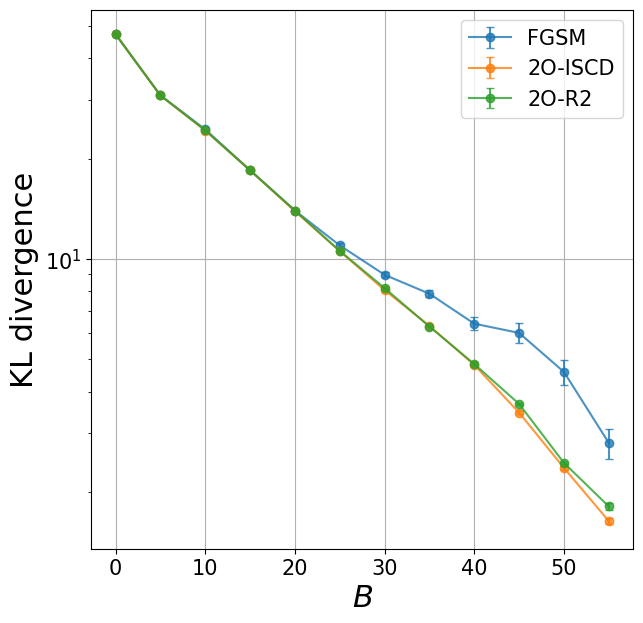

In [12]:
error_bar_scale = 1.96
not_show = []
plt.figure(figsize=(7, 7))

mu_ast, v_ast, a_ast, b_ast = model.posterior_parameters(data) 
tau_post = Gamma(a_ast, b_ast)
beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

original_KL = float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post))

for heuristic in results.keys():
    
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic)+1)
    KL_stds = torch.zeros(len(results_heuristic)+1)
    KL_means[0] = original_KL
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]["KLs"]
        KL_means[i+1] = KL_repeats.mean()
        KL_stds[i+1] = KL_repeats.std() / np.sqrt(len(KL_repeats))

    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.yscale('log')
plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

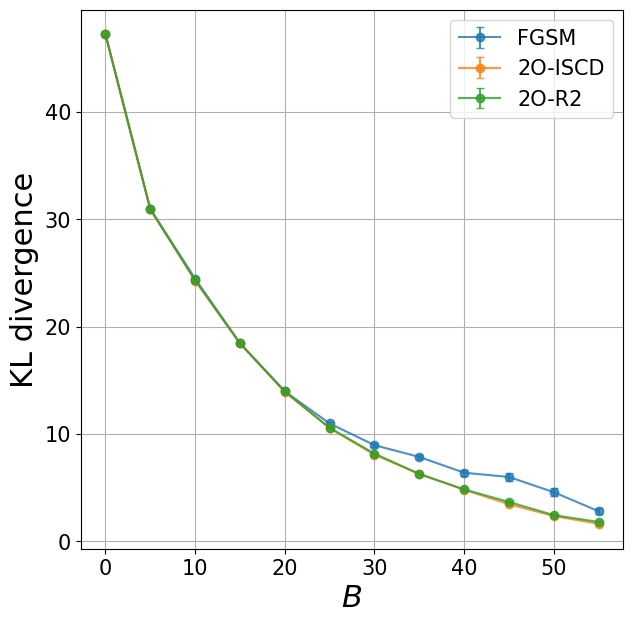

In [13]:

plt.figure(figsize=(7, 7))
for heuristic in results.keys():
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic)+1)
    KL_stds = torch.zeros(len(results_heuristic)+1)
    KL_means[0] = original_KL
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]["KLs"]
        KL_means[i+1] = KL_repeats.mean()
        KL_stds[i+1] = KL_repeats.std() / np.sqrt(len(KL_repeats))

    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## STD over the slope

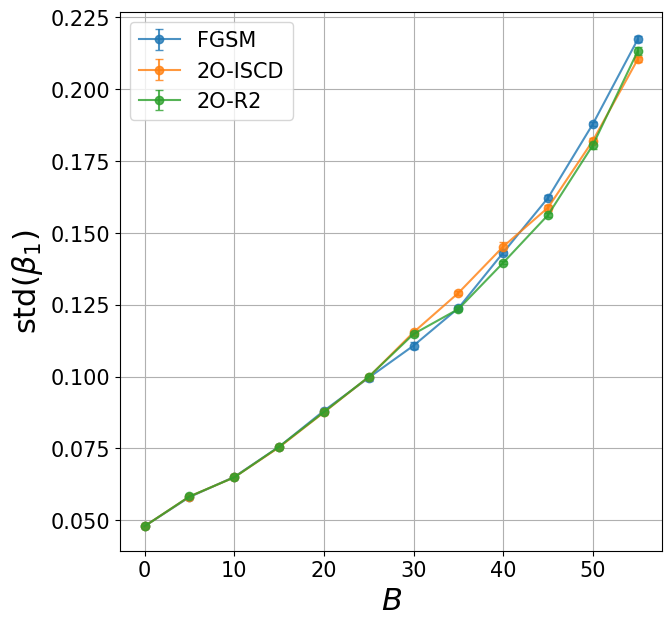

In [14]:
n_samples_post = 10000
torch.manual_seed(0)

not_show = []
plt.figure(figsize=(7, 7))

samples_orig = model.sample_posterior(n_samples_post, data)
std_original = torch.std(samples_orig["beta"][:, idx_covariate])

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    std_means = torch.zeros(len(results_heuristic) + 1)
    std_stds = torch.zeros(len(results_heuristic) + 1)
    std_means[0] = std_original

    for i, max_L1 in enumerate(results_heuristic.keys()):
        n = len(results_heuristic[max_L1]["weights"])
        std_repeats = torch.zeros(n)

        for j in range(n):
            samples = model.sample_posterior(n_samples_post, data, weights=results_heuristic[max_L1]["weights"][j])
            std_repeats[j] = torch.std(samples["beta"][:, idx_covariate])

        std_means[i + 1] = std_repeats.mean()

        std_stds[i + 1] = std_repeats.std() / np.sqrt(n)

    plt.errorbar([0] + list(results_heuristic.keys()), std_means, yerr=std_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("std$(\\beta_1)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## $\sqrt{\Sigma_{w, 1, 1}}$

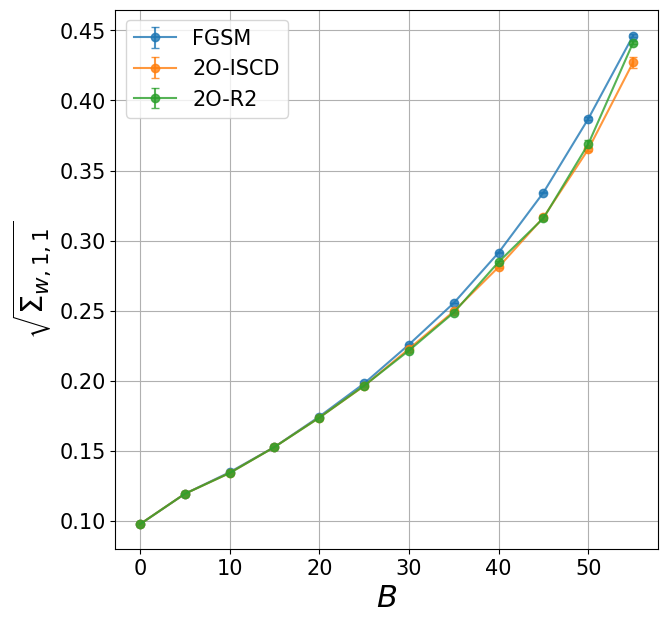

In [15]:
error_bar_scale = 1.96
not_show = []
plt.figure(figsize=(7, 7))

mu_ast, v_ast, a_ast, b_ast = model.posterior_parameters(data) 
std_orig = torch.sqrt(v_ast[1, 1])

for heuristic in results.keys():
    
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    std_means = torch.zeros(len(results_heuristic) + 1)
    std_stds = torch.zeros(len(results_heuristic) + 1)
    std_means[0] = std_orig

    for i, max_L1 in enumerate(results_heuristic.keys()):
        std_repeats = torch.sqrt(results_heuristic[max_L1]["cov"][:, 1, 1])
        std_means[i + 1] = std_repeats.mean()
        std_stds[i + 1] = std_repeats.std() / np.sqrt(len(std_repeats))

    plt.errorbar([0] + list(results_heuristic.keys()), std_means, yerr=std_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$\\sqrt{\\Sigma_{w, 1, 1}}$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## Mean parameter value

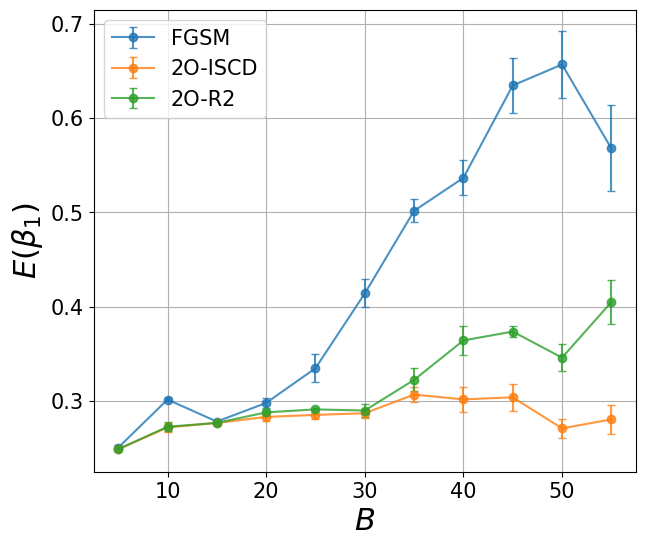

In [16]:
error_bar_scale = 1.96
not_show = ["2O-R2-m"] #["2O-R2-m", "SGD-R2"]
plt.figure(figsize=(7, 6))

for heuristic in results.keys():
    
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    mean_means = torch.zeros(len(results_heuristic))
    mean_stds = torch.zeros(len(results_heuristic))
    for i, max_L1 in enumerate(results_heuristic.keys()):
        mean_repeats = results_heuristic[max_L1]["mean"][:, 1]
        mean_means[i] = mean_repeats.mean()
        mean_stds[i] = mean_repeats.std() / np.sqrt(len(mean_repeats))
    #print(KL_stds)
    label = "2O-EMA-R2" if heuristic == "2O-R2-m" else heuristic # consistency of notations
    plt.errorbar(results_heuristic.keys(), mean_means, yerr=mean_stds*error_bar_scale, alpha=0.8, label=label, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$E(\\beta_1)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## Probability of negative parameter

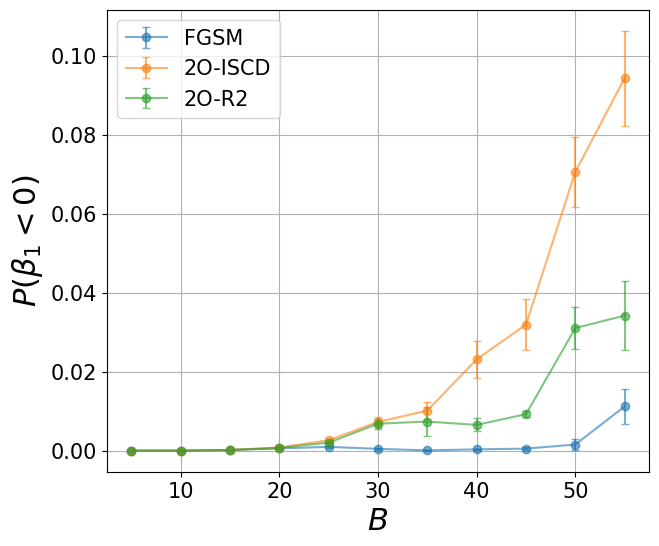

In [17]:
threshold = 0.0
n_samples_post = 10000
torch.manual_seed(0)

not_show = []#["2O-R2-m"]
plt.figure(figsize=(7, 6))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic))
    prob_neg_stds = torch.zeros(len(results_heuristic))

    for i, max_L1 in enumerate(results_heuristic.keys()):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = torch.zeros(n)

        for j in range(n):
            samples = model.sample_posterior(n_samples_post, data, weights=results_heuristic[max_L1]["weights"][j])
            prob_neg_repeats[j] = torch.sum(samples["beta"][:, idx_covariate] < threshold) / n_samples_post

        prob_neg_means[i] = prob_neg_repeats.mean()

        prob_neg_stds[i] = prob_neg_repeats.std() / np.sqrt(n)


    label = "2O-EMA-R2" if heuristic == "2O-R2-m" else heuristic # consistency of notations
    plt.errorbar(results_heuristic.keys(), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.6, label=label, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_1 < 0)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## Regression lines and beta posteriors

In [18]:
CLR_ORIGINAL = "Green"
CLR_TARGET = "Red"
CLR_TAINTED = "Blue"

n_samples_plot = 5000

colors = [CLR_ORIGINAL, CLR_TARGET, CLR_TAINTED]

def make_plots(final_weights, 
               plot_datapoints=False,
               scatter_marginal_beta=False,
               plot_marginal_beta_from_samples=False,
               plot_marginal_beta=False, 
               plot_conditional_beta=False,
               plot_marginal_tau=False):

    original_posterior_samples = model.sample_posterior(n_samples_plot, data)["beta"].data
    original_mean_beta = original_posterior_samples.mean(dim=0)

    attacked_posterior_samples = model.sample_posterior(n_samples_plot, data, weights=final_weights)["beta"].data
    attacked_mean_beta = attacked_posterior_samples.mean(dim=0)

    # Original dist
    mu_post, cov_post, a_post, b_post = model.posterior_parameters(data)
    tau_orig = Gamma(a_post, b_post)
    beta_orig = MultivariateNormal(mu_post, cov_post / tau_orig.mean)

    # Tainted dist
    mu_post, cov_post, a_post, b_post = model.posterior_parameters(data, weights=final_weights)
    tau_tainted = Gamma(a_post, b_post)
    beta_tainted = MultivariateNormal(mu_post, cov_post / tau_tainted.mean)

    beta_distributions = [beta_orig, beta_adv_dist, beta_tainted]
    tau_distributions = [tau_orig, tau_adv_dist, tau_tainted]

    # Choose the area to display
    lim_inf = mu_post.clone() # (x_min, y_min)
    lim_sup = mu_post.clone() # (x_max, y_max)

    scale_std = 3
    for dist in beta_distributions:
        mean = dist.mean
        stds = torch.sqrt(dist.covariance_matrix.diag())
        lim_inf = torch.min(torch.vstack((lim_inf, mean - scale_std*stds)), dim=0)[0]
        lim_sup = torch.max(torch.vstack((lim_sup, mean + scale_std*stds)), dim=0)[0]
    
    lim_inf = lim_inf.data.numpy()
    lim_sup = lim_sup.data.numpy()
    
    if plot_datapoints:
        # Plot the datapoints and the mean regression lines
        def plot_regression_line(mu, color, label, linestyle=None):
            x1 = X[:, 1].min().detach()
            x2 = X[:, 1].max().detach()

            y1 = mu[0] + x1*mu[1]
            y2 = mu[0] + x2*mu[1]
            plt.plot([x1, x2], [y1, y2], 
                    color=color, label=label, linestyle=linestyle)


        plt.figure(figsize=(7, 7))

        plot_regression_line(original_mean_beta, CLR_ORIGINAL, "$Y = [1, X] \\cdot \\mu_{n, w=1} $") # "Mean regression line without attack" "$Y = E_{w=1}(\\beta)^\\top [1, X]$"
        plot_regression_line(attacked_mean_beta.detach(), CLR_TAINTED, "$Y =   [1, X] \\cdot \\mu_{n, w*}$") # "Mean regression line with attack"
        plot_regression_line(muA, CLR_TARGET, "$Y =  [1, X] \\cdot \\mu_A$") # "Mean target regression line"

        # Plot the datapoints
        plt.scatter(X.data[:, 1:], y.data, color="gray", alpha=0.5)

        # Plot the + and - symbols
        plt.scatter(X.data[:, 1:], y.data, color="red", marker='_', alpha=(final_weights < 1).data)
        plt.scatter(X.data[:, 1:], y.data, color="green", marker='+', alpha=(final_weights > 1).data)
        plt.scatter([], [], color="red", marker='_',  label="$w^*_i=0$") # "Removed points"
        plt.scatter([], [], color="green", marker='+', label="$w^*_i=2$") # "Duplicated points"
        plt.grid(True)
        plt.xlabel("X", fontsize=AX_LBL_SIZE)
        plt.ylabel("Y", fontsize=AX_LBL_SIZE)
        plt.legend(fontsize=13, loc="upper left")
        plt.xticks(fontsize=TICKS_LBL_SIZE)
        plt.yticks(fontsize=TICKS_LBL_SIZE)
        plt.show()


    if scatter_marginal_beta:
        plt.figure(figsize=(7, 7))
        plt.scatter(*attacked_posterior_samples.T.detach(), color=CLR_TAINTED,
                    label="attacked posterior", marker='.', alpha=0.5)
        plt.scatter(*original_posterior_samples.T, color=CLR_ORIGINAL,
                    label="original posterior", marker='.', alpha=0.5)
        plt.scatter(*sample_adv(1000)["beta"].T, color=CLR_TARGET,
                    label="target posterior", marker='.', alpha=0.5)
        
        plt.legend()
        plt.grid(True)
        #plt.title("Posterior comparisons (conditional dist on $\\beta$)")
        plt.xlabel("$\\beta_0$", fontsize=14)
        plt.ylabel("$\\beta_1$", fontsize=14)
        plt.axis("square")
        plt.show()


    if plot_marginal_beta_from_samples:
        # Plot the distributions over beta using empirical level lines
        plt.figure(figsize=(7, 7))
        
        levels = 5#[0.25, 0.5, 0.75]
        adv_samples = sample_adv(n_samples_plot)["beta"]
        sns.kdeplot(x=original_posterior_samples[:, 0], 
                    y=original_posterior_samples[:, 1], 
                    cmap=CLR_ORIGINAL + "s", levels=levels)
        sns.kdeplot(x=adv_samples[:, 0], 
                    y=adv_samples[:, 1], 
                    cmap=CLR_TARGET + "s", levels=levels)
        sns.kdeplot(x=attacked_posterior_samples[:, 0], 
                    y=attacked_posterior_samples[:, 1], 
                    cmap=CLR_TAINTED + "s", levels=levels)
        
        plt.xlabel("$\\beta_0$", fontsize=14)
        plt.ylabel("$\\beta_1$", fontsize=14)
        #plt.title('Marginal distributions over beta')
        plt.plot([], [], color=CLR_ORIGINAL, label="Original posterior")
        plt.plot([], [], color=CLR_TARGET, label="Target posterior")
        plt.plot([], [], color=CLR_TAINTED, label="Tainted posterior")
        plt.grid(True)
        plt.legend()
        plt.show()

    if plot_marginal_beta:
        resolution = 1000
        n_tau_samples = 100
        cell_surface = (resolution - 1)**2 / (lim_sup[0] - lim_inf[0]) / (lim_sup[1] - lim_inf[1])

        quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]

        # Plot the distributions over beta using conditional beta
        
        plt.figure(figsize=(7, 7))
        x_axis = np.linspace(lim_inf[0], lim_sup[0], 1000)
        y_axis = np.linspace(lim_inf[1], lim_sup[1], 1000)
        XX, YY = np.meshgrid(x_axis, y_axis)
        grid = np.stack([XX.ravel(), YY.ravel()], axis=-1)
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        

        for beta_dist, tau_dist, clr in zip(beta_distributions, tau_distributions, colors):
            pdf_values = to_np(torch.zeros(grid_tensor.shape[0]))
            for i in range(n_tau_samples):
                tau = tau_dist.sample()
                conditional_beta = MultivariateNormal(beta_dist.mean, beta_dist.covariance_matrix / tau * tau_dist.mean)
                pdf_values += torch.exp(conditional_beta.log_prob(grid_tensor)).data.numpy()

            Z = pdf_values.reshape(XX.shape) / n_tau_samples / cell_surface
            Z_flat = Z.reshape(-1)
            arg = np.argsort(Z_flat)
            quantiles_function = np.cumsum(Z_flat[arg])

            levels = []
            for q in quantiles:
                idx = np.argmin(np.abs(quantiles_function - q))
                levels.append(Z_flat[arg][idx])
            
            plt.contour(XX, YY, Z, levels=levels, cmap=clr + "s")#colors=clr)

        if decrease_uncertainty:
            plt.xlim(0.52, 0.65)
            plt.ylim(0.18, 0.31)
        else:
            plt.xlim(0.3, 0.9)
            plt.ylim(0.0, 0.6)
            
        plt.plot([], [], color=CLR_ORIGINAL, label="Original posterior")
        plt.plot([], [], color=CLR_TARGET, label="Target posterior")
        plt.plot([], [], color=CLR_TAINTED, label="Tainted posterior")
        plt.grid(True)
        plt.xlabel("$\\beta_0$", fontsize=AX_LBL_SIZE)
        plt.ylabel("$\\beta_1$", fontsize=AX_LBL_SIZE)
        plt.legend(fontsize=LEGEND_LBL_SIZE)
        plt.xticks(fontsize=TICKS_LBL_SIZE)
        plt.yticks(fontsize=TICKS_LBL_SIZE)
        plt.show()

    if plot_conditional_beta:
        # Plot the distributions over beta using conditional beta
        
        plt.figure(figsize=(7, 7))
        x_axis = np.linspace(lim_inf[0], lim_sup[0], 1000)
        y_axis = np.linspace(lim_inf[1], lim_sup[1], 1000)
        XX, YY = np.meshgrid(x_axis, y_axis)
        grid = np.stack([XX.ravel(), YY.ravel()], axis=-1)
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        

        for dist, clr in zip(beta_distributions, colors):
            pdf_values = torch.exp(dist.log_prob(grid_tensor)).data.numpy()
            Z = pdf_values.reshape(XX.shape)
            plt.contour(XX, YY, Z, levels=None, colors=clr)

        plt.plot([], [], color=CLR_TARGET, label="Target posterior")
        plt.plot([], [], color=CLR_ORIGINAL, label="Original posterior")
        plt.plot([], [], color=CLR_TAINTED, label="Tainted posterior")

        plt.legend()
        plt.grid(True)
        plt.xlabel("$\\beta_0$", fontsize=14)
        plt.ylabel("$\\beta_1$", fontsize=14)
        plt.axis("square")
        plt.show()

    if plot_marginal_tau:
        # Plot the distributions over tau
        
        max_tau = 0
        scale_factor = 3
        for dist in tau_distributions:
            max_tau = max(max_tau, dist.mean * scale_factor)
        
        xx = torch.linspace(0, max_tau, 1000)

        for dist, clr in zip(tau_distributions, colors):
            pdf_values = torch.exp(dist.log_prob(xx)).data.numpy()
            plt.plot(xx, pdf_values, color=clr, alpha=0.6)

        plt.plot([], [], color=CLR_TARGET, label="Target posterior", alpha=0.6)
        plt.plot([], [], color=CLR_ORIGINAL, label="Original posterior", alpha=0.6)
        plt.plot([], [], color=CLR_TAINTED, label="Tainted posterior", alpha=0.6)

        plt.legend()
        plt.grid(True)
        plt.xlabel("$\\tau$", fontsize=14)
        plt.ylabel("pdf", fontsize=14)
        plt.show()


### 1 plot for each heuristic

In [19]:
results["2O-R2"][40]["weights"][-1]

tensor([0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

FGSM
40.0


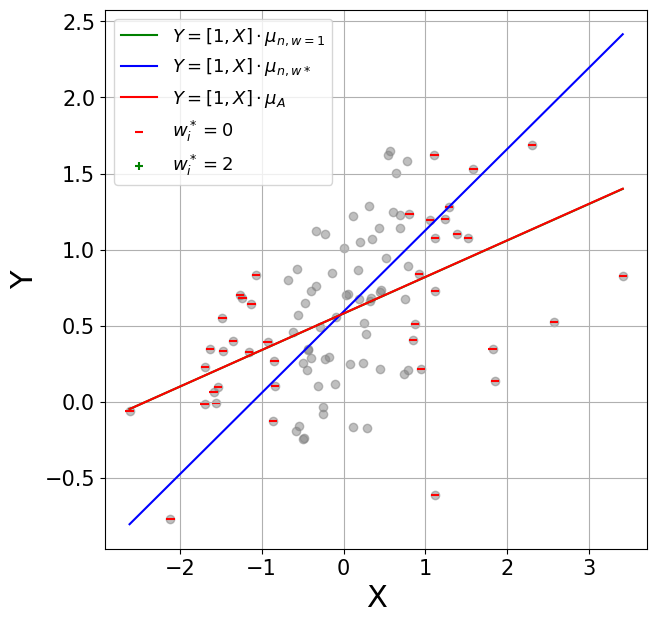

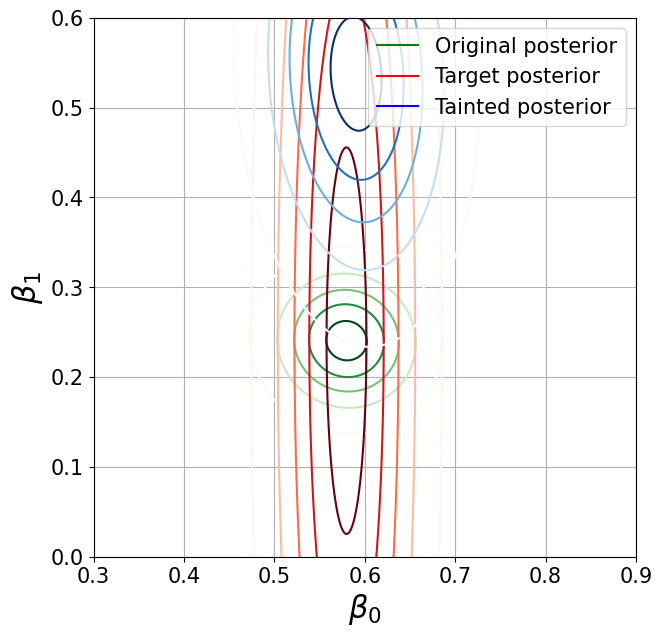

2O-ISCD
40.0


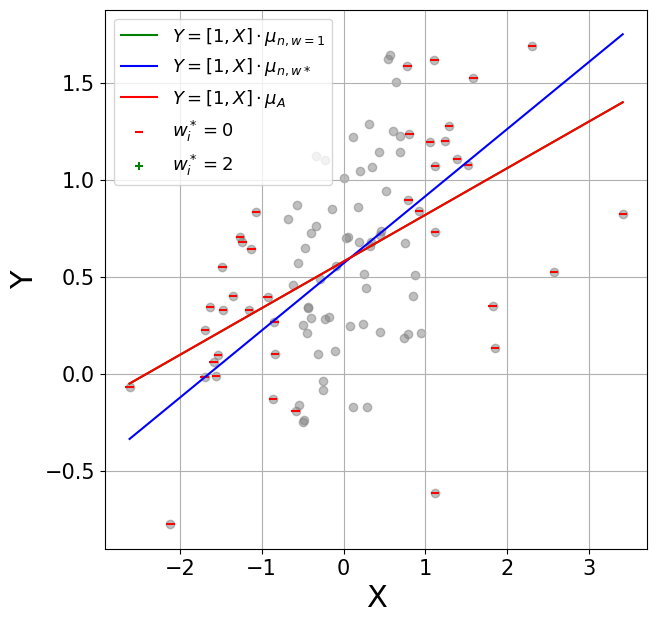

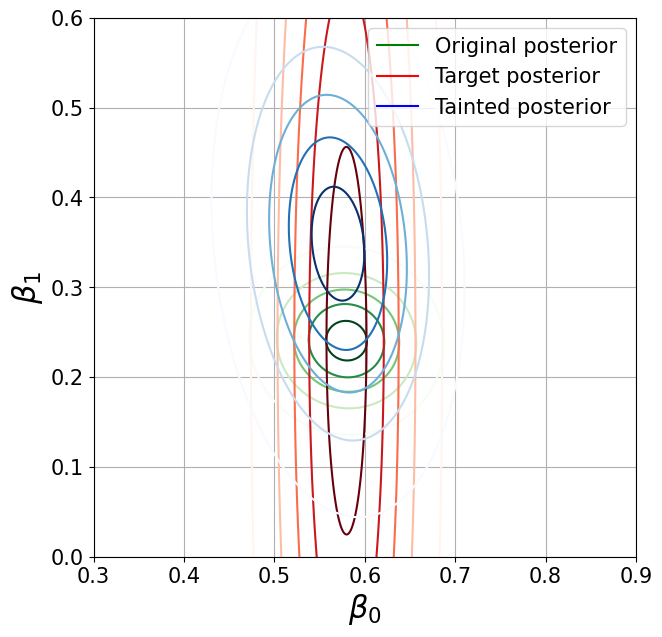

2O-R2
40.0


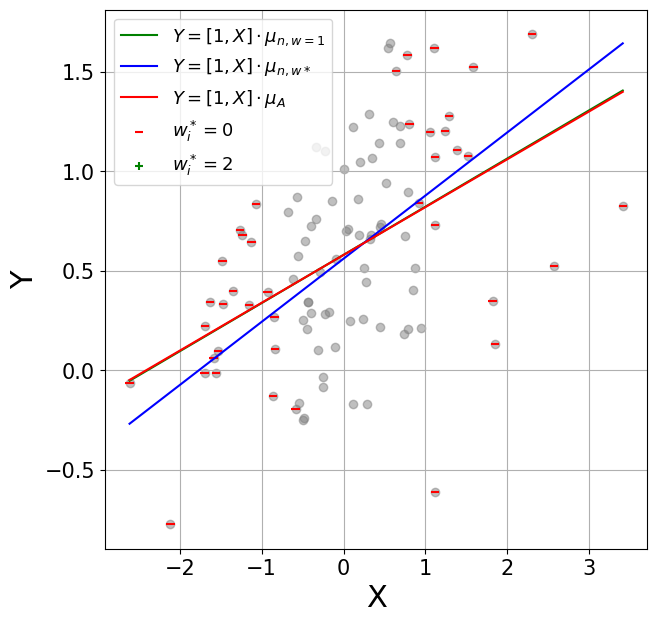

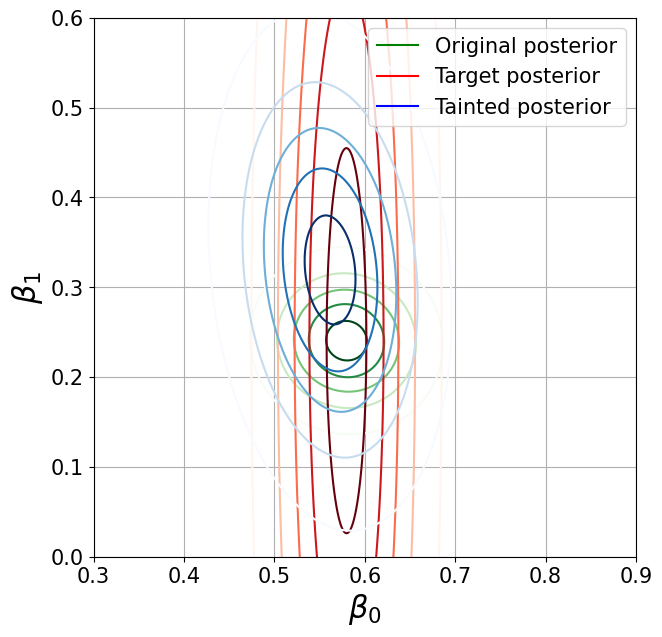

In [20]:
max_L1 = 40
torch.manual_seed(0)

for heuristic in results.keys():
    print(heuristic)
    print(to_np(torch.norm(torch.ones(n_points)- results[heuristic][max_L1]["weights"][-1], p=1)))
    make_plots(results[heuristic][max_L1]["weights"][-1],
               plot_datapoints=True,
               scatter_marginal_beta=False,
               plot_marginal_beta=True, 
               plot_conditional_beta=False,
               plot_marginal_tau=False)

### 1 plot for each L1

In [21]:
heuristic = "2O-ISCD"

max L1 = 30
30.0


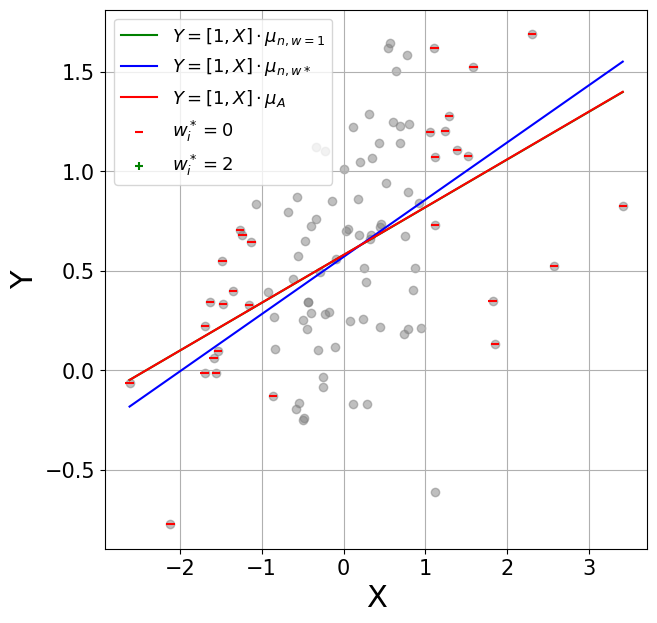

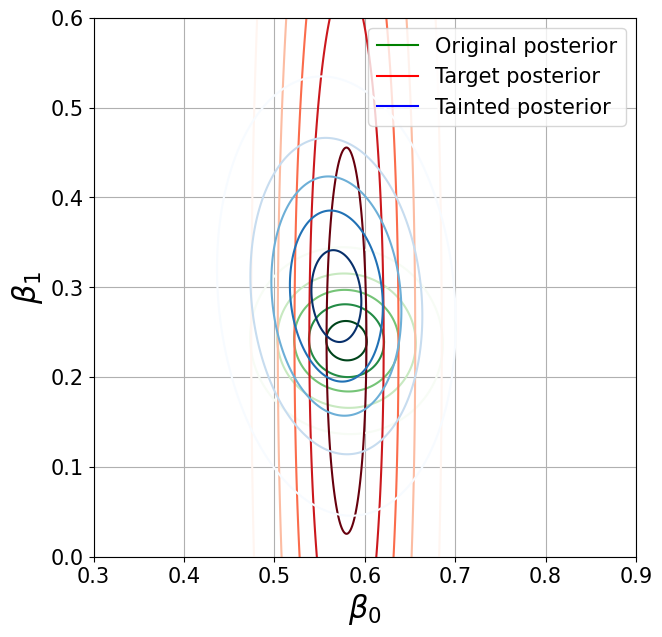

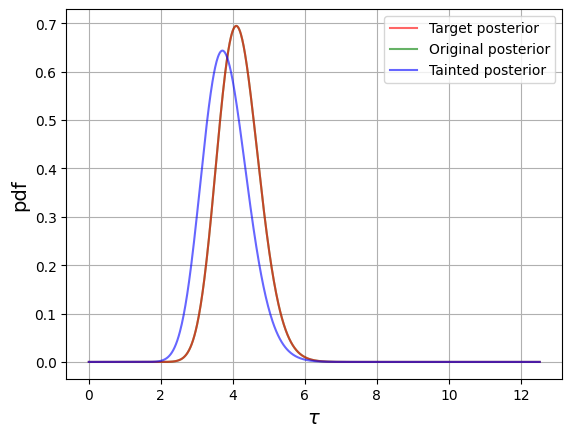

max L1 = 35
35.0


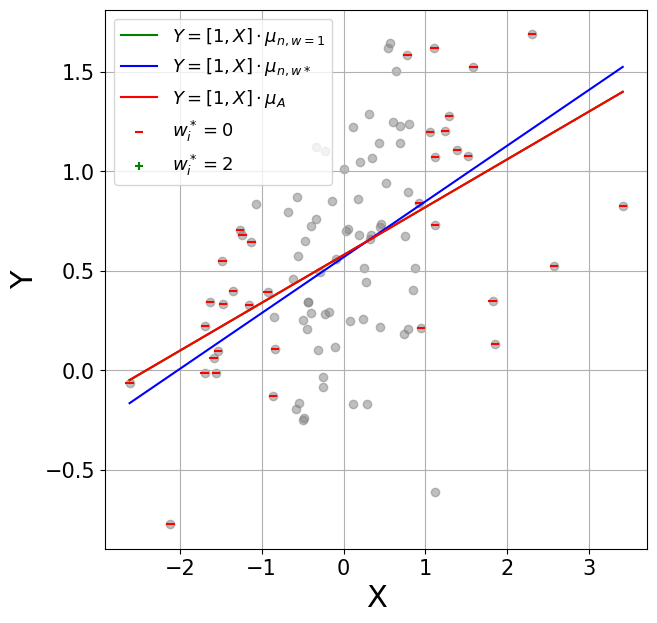

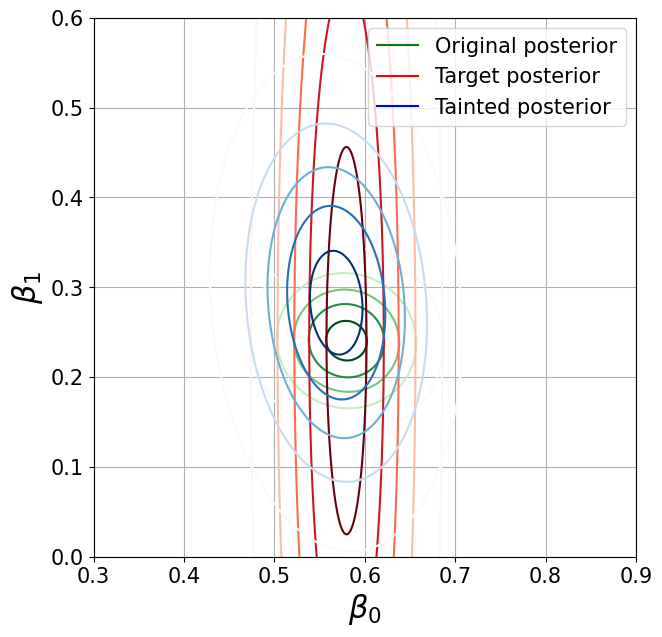

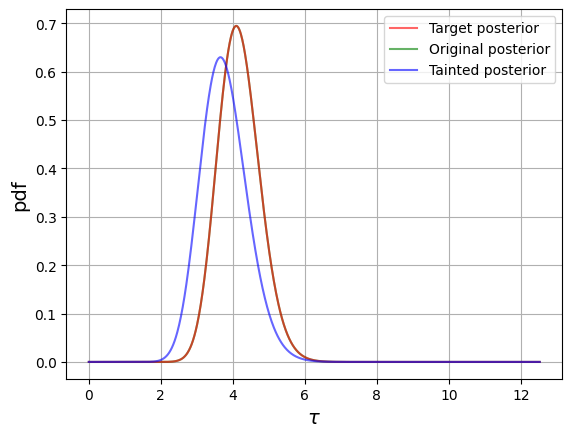

max L1 = 40
40.0


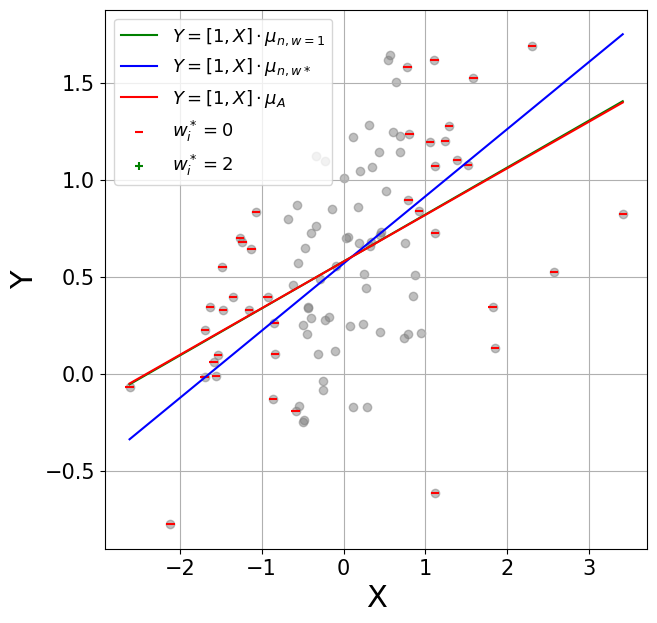

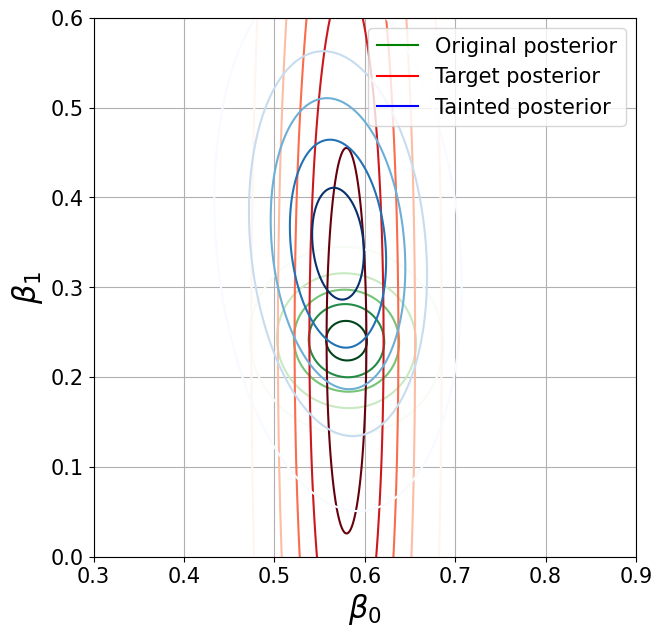

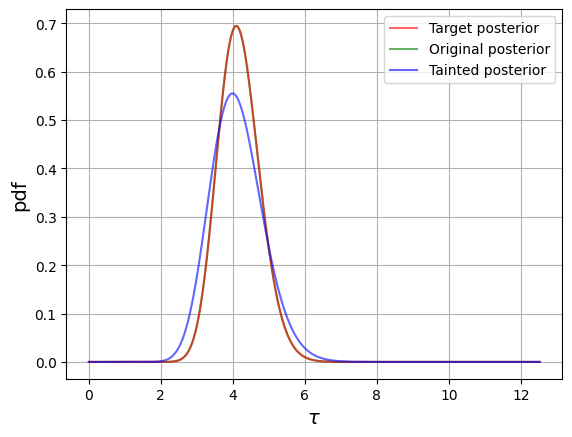

max L1 = 45
45.0


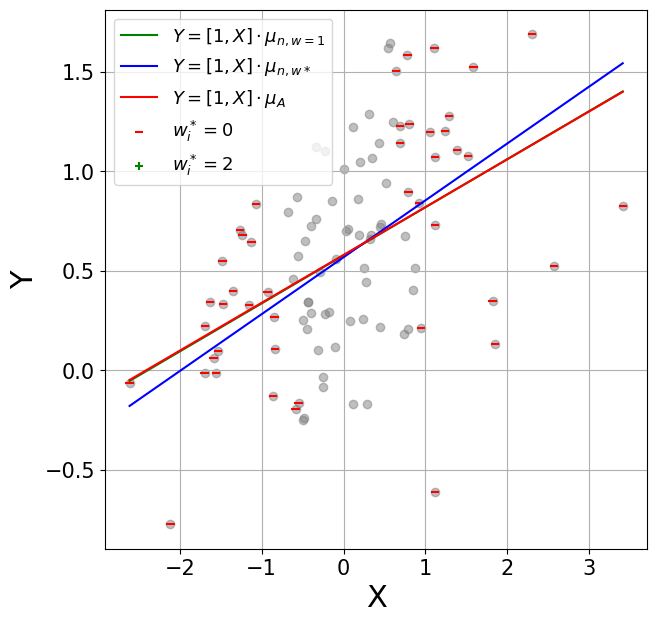

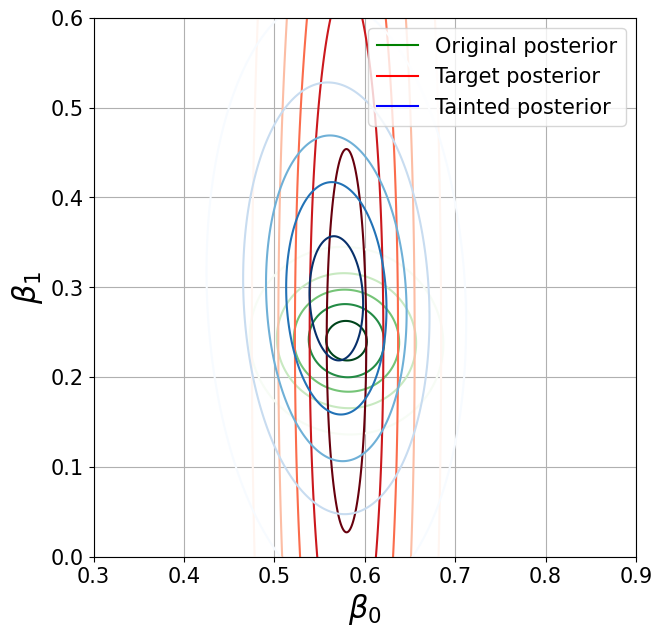

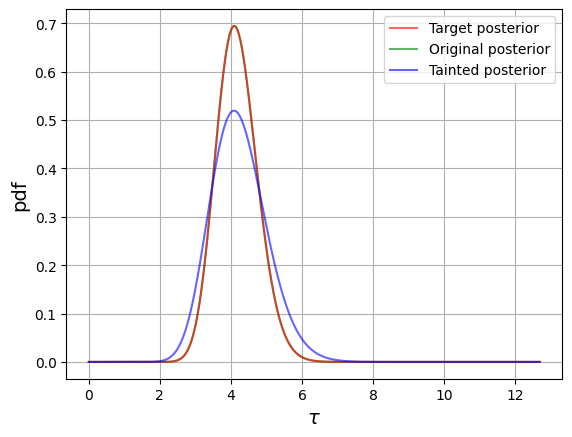

max L1 = 50
50.0


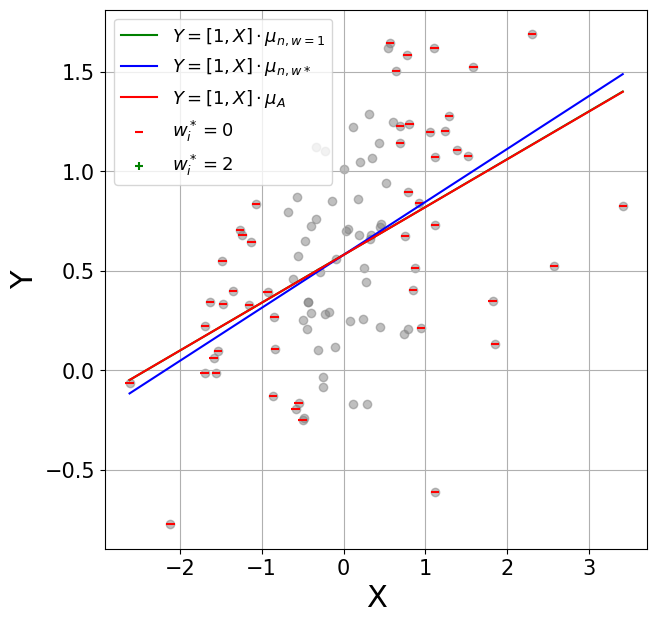

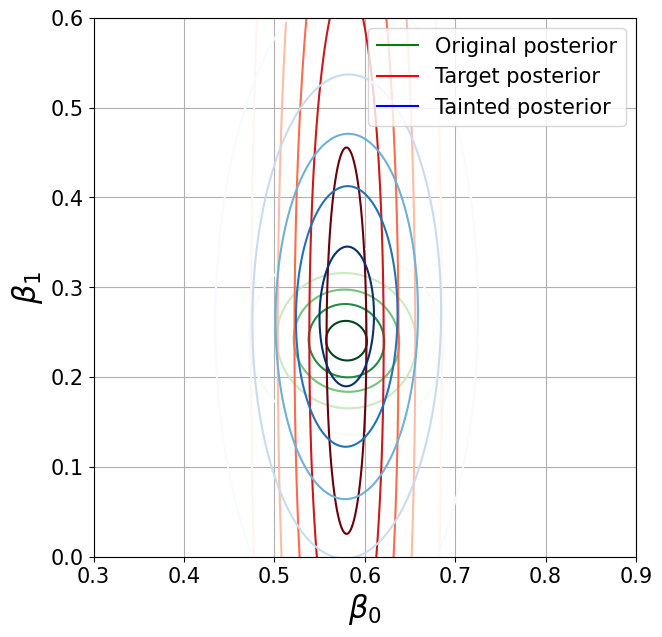

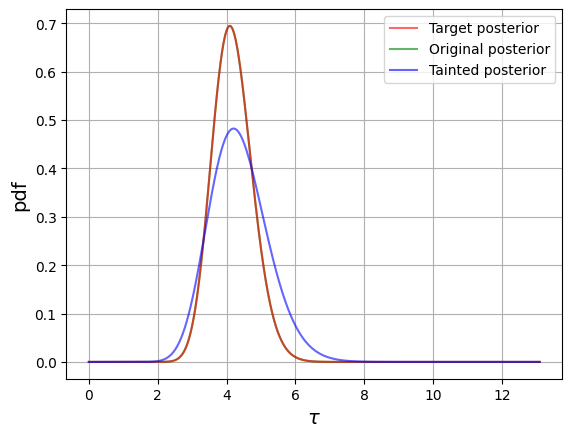

In [22]:
max_L1_plot = [30, 35, 40, 45, 50]
torch.manual_seed(0)

for max_L1 in max_L1_plot:
    print("max L1 =", max_L1)
    print(to_np(torch.norm(torch.ones(n_points)- results[heuristic][max_L1]["weights"][-1], p=1)))
    make_plots(results[heuristic][max_L1]["weights"][-1],
               plot_datapoints=True,
               scatter_marginal_beta=False,
               plot_marginal_beta=True, 
               plot_conditional_beta=False,
               plot_marginal_tau=True)